In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max.columns', None)

import plotly.graph_objects as go

from warnings import filterwarnings
filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


In [3]:
df_stock_prices = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')

df_options = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv')

df_secondary_stock_prices = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv')

df_trades = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/trades.csv')

df_financials = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv')

df_stock_list = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv')

<AxesSubplot:>

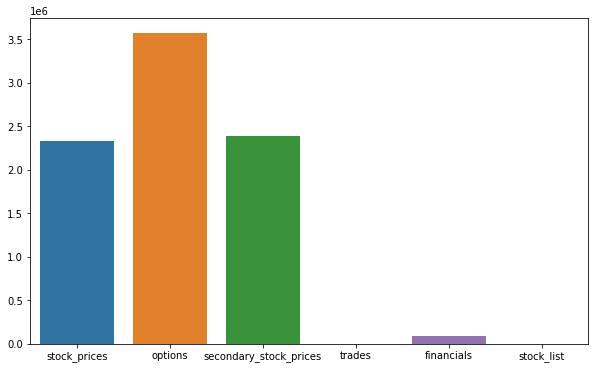

In [4]:
# size of all datasets

datasets = [df_stock_prices,df_options,df_secondary_stock_prices,df_trades,df_financials,df_stock_list]

labels = ['stock_prices','options','secondary_stock_prices','trades','financials','stock_list']

sizes = [len(i) for i in datasets]

plt.figure(figsize = (10,6))

sns.barplot(x = labels , y = sizes)

In [5]:
tuple(zip(labels,sizes))

(('stock_prices', 2332531),
 ('options', 3567694),
 ('secondary_stock_prices', 2384575),
 ('trades', 1712),
 ('financials', 92956),
 ('stock_list', 4417))

#Analysing the core dataset: Stock Prices

In [6]:
df_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [7]:
df_stock_prices.shape

(2332531, 12)

In [8]:
df_stock_prices.dtypes

RowId                object
Date                 object
SecuritiesCode        int64
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
AdjustmentFactor    float64
ExpectedDividend    float64
SupervisionFlag        bool
Target              float64
dtype: object

In [9]:
# convert date to datetime

df_stock_prices['Date'] = pd.to_datetime(df_stock_prices['Date'])

df_stock_prices['Year'] = df_stock_prices['Date'].dt.year

df_stock_prices['Month'] = df_stock_prices['Date'].dt.month

df_stock_prices['Day'] = df_stock_prices['Date'].dt.day

<AxesSubplot:>

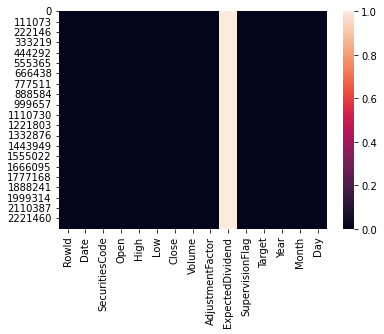

In [10]:
sns.heatmap(df_stock_prices.isnull())

Expected Dividend column contains mostly null values. We can drop this column along with row id.

In [11]:
# drop expected dividend

df_stock_prices.drop(['ExpectedDividend', 'RowId'], axis = 1, inplace = True, errors = 'ignore')

In [12]:
# check records with missing prices

df_stock_prices[df_stock_prices['Close'].isnull()].shape

(7608, 13)

In [13]:
df_stock_prices[df_stock_prices['Close'].isnull()].head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,Year,Month,Day
401,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,False,NaN,2017,1,4
1753,2017-01-04,9539,NaN,NaN,NaN,NaN,0,1.0,False,-0.004149,2017,1,4
2266,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,False,NaN,2017,1,5
2511,2017-01-05,4621,NaN,NaN,NaN,NaN,0,1.0,False,0.000000,2017,1,5
4131,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,False,NaN,2017,1,6


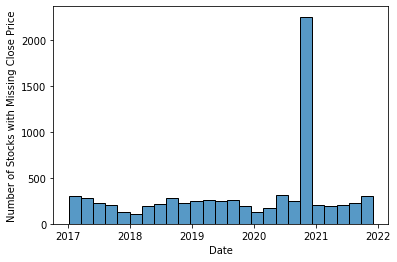

In [14]:
sns.histplot(df_stock_prices[df_stock_prices['Close'].isnull()]['Date'].sort_values())

plt.xlabel('Date')

plt.ylabel('Number of Stocks with Missing Close Price')

plt.show()

We see a spike in missing information towards the end of 2020. 

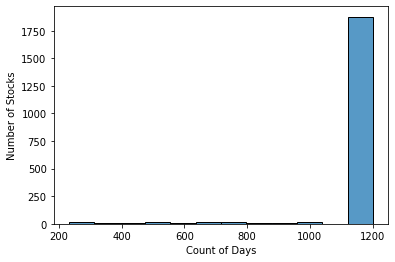

In [15]:
# how many days information does each stock have?

sns.histplot(df_stock_prices.groupby('SecuritiesCode').size())

plt.xlabel('Count of Days')

plt.ylabel('Number of Stocks')

plt.show()

Most stocks contain information of 1100-1200 days.

Text(0, 0.5, 'Number of stocks')

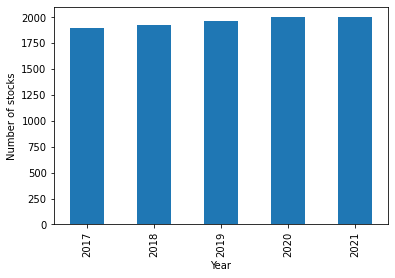

In [16]:
# Number of unique stocks per year

stocks_unique = df_stock_prices[['Year','SecuritiesCode']].drop_duplicates()

stocks_unique.groupby(['Year']).size().plot(kind = 'bar')

plt.ylabel('Number of stocks')

The number of unique stocks gradually increase over the years.

# Stock List

([], [])

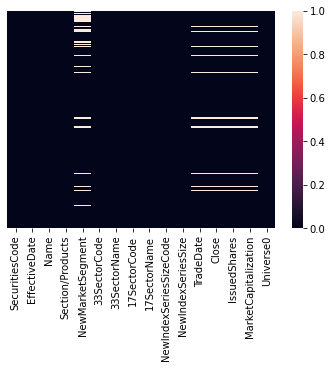

In [17]:
# missing values

sns.heatmap(df_stock_list.isnull())

plt.yticks([])

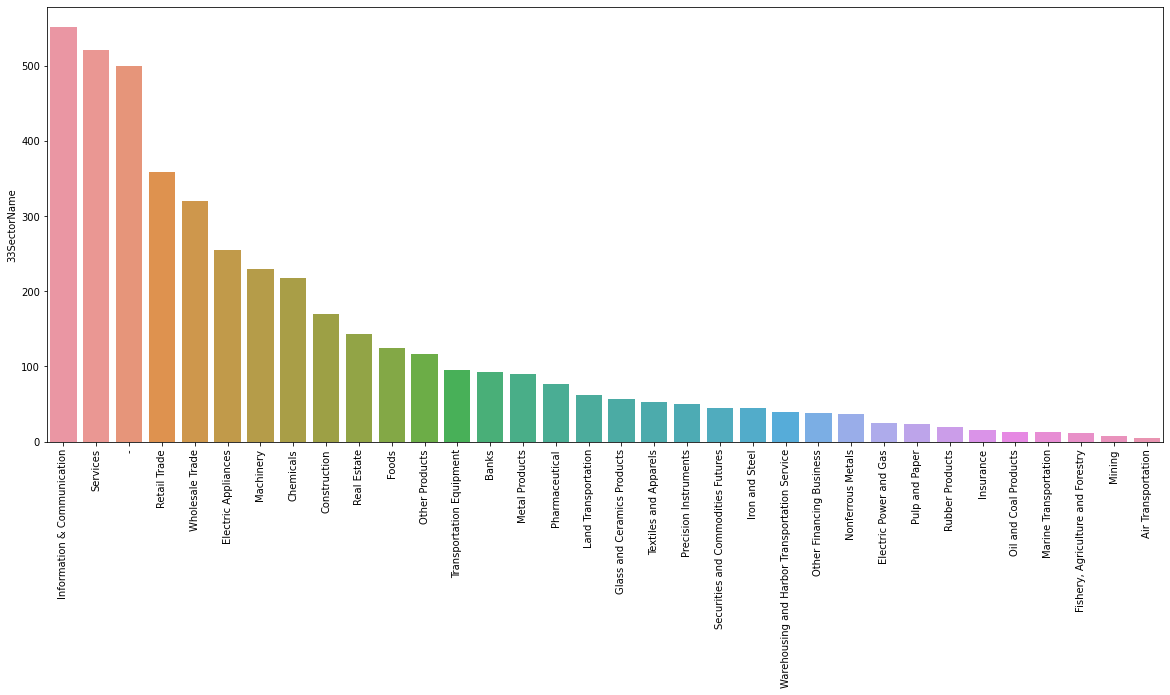

In [18]:
# industry distribution

plt.figure(figsize = (20,8))


y = df_stock_list['33SectorName'].value_counts().sort_values(ascending = False)
x = df_stock_list['33SectorName'].value_counts().sort_values(ascending = False).index
sns.barplot(x=x,y=y)

plt.xticks(rotation = 90)

plt.show()

# Exploring the target

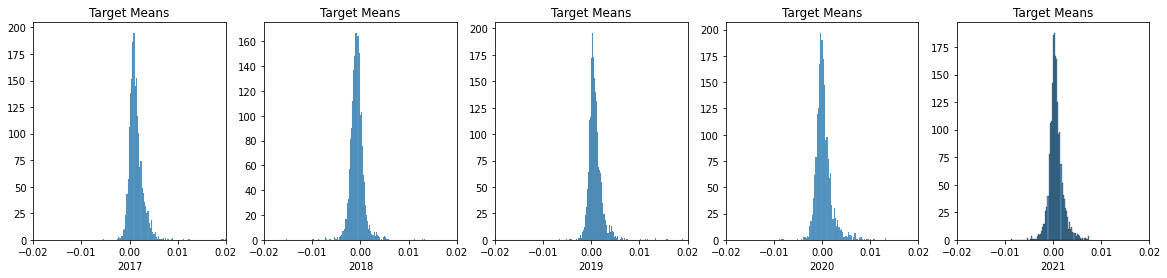

In [20]:
# the mean target distribution for each stock in each year

df_annual_mean_target = df_stock_prices.groupby(['Year','SecuritiesCode'])['Target'].mean().unstack(level = 0)

year = 2017
fig = plt.figure(figsize = (20,4))

for i in range(1,6):
  plt.subplot(1,5,i)
  sns.histplot(df_annual_mean_target[year])
  plt.xlim([-0.02,+0.02])
  plt.ylabel('')
  plt.title('Target Means')
  year+=1

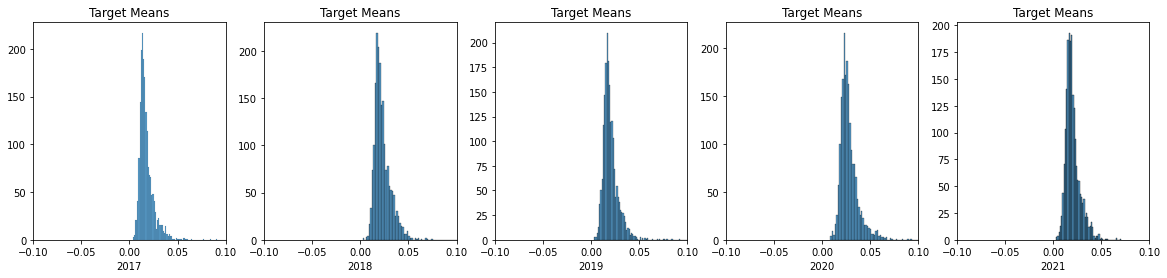

In [22]:
# standard deviation of the target means in each year

df_annual_std_target = df_stock_prices.groupby(['Year','SecuritiesCode'])['Target'].std().unstack(level = 0)

year = 2017
fig = plt.figure(figsize = (20,4))

for i in range(1,6):
  plt.subplot(1,5,i)
  sns.histplot(df_annual_std_target[year])
  plt.xlim([-0.1,0.1])
  plt.ylabel('')
  plt.title('Target Means')
  year+=1

In [23]:
# looking at sectors

# join the table

df_stock_prices_with_info = pd.merge(df_stock_prices,df_stock_list, on = 'SecuritiesCode')

In [24]:
# number of sectors

df_stock_prices_with_info['33SectorName'].nunique()

33

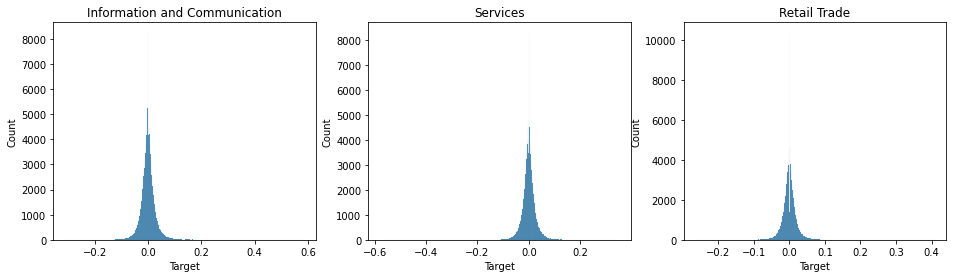

In [25]:
# target for major sectors

fig = plt.figure(figsize = (16,4))
plt.subplot(1,3,1)
sns.histplot(df_stock_prices_with_info[df_stock_prices_with_info['33SectorName']=='Information & Communication']['Target'])
plt.title('Information and Communication')

plt.subplot(1,3,2)
sns.histplot(df_stock_prices_with_info[df_stock_prices_with_info['33SectorName']=='Services']['Target'])
plt.title('Services')

plt.subplot(1,3,3)
sns.histplot(df_stock_prices_with_info[df_stock_prices_with_info['33SectorName']=='Retail Trade']['Target'])
plt.title('Retail Trade')

plt.show()

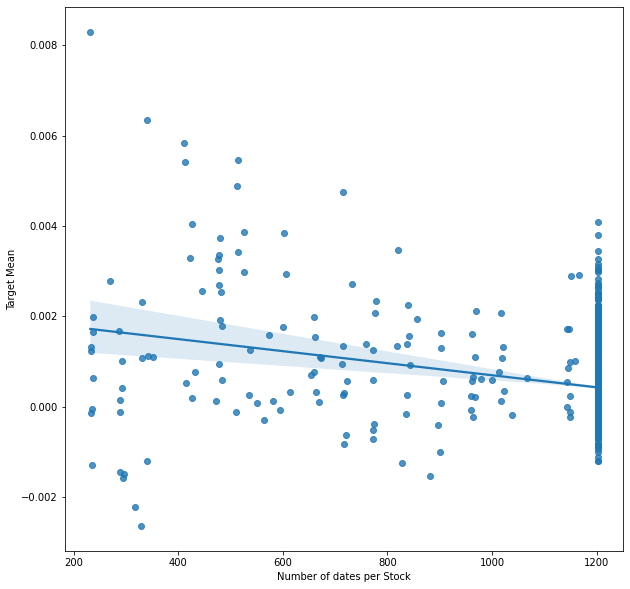

In [26]:
n_stocks_per_date = df_stock_prices.groupby(['Date'])['SecuritiesCode'].count()
n_dates_per_stock = df_stock_prices.groupby(['SecuritiesCode'])['Date'].count()
target_mean_per_stock = df_stock_prices.groupby(['SecuritiesCode'])['Target'].mean()


plt.figure(figsize = (10,10))
sns.regplot(x=n_dates_per_stock, y=target_mean_per_stock)
plt.xlabel('Number of dates per Stock')
plt.ylabel('Target Mean')
plt.show()

# Analyze 1 random stock

In [27]:
# extract all the closing prices

df_any_one_stock = df_stock_prices[df_stock_prices['SecuritiesCode']==1332]

In [28]:
df_any_one_stock.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,Year,Month,Day
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,False,0.012324,2017,1,4
1866,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,False,-0.022609,2017,1,5
3731,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,False,-0.016014,2017,1,6
5596,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,False,-0.016275,2017,1,10
7461,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,False,0.016544,2017,1,11


In [29]:
from plotly.subplots import make_subplots

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=df_any_one_stock['Date'],y=df_any_one_stock['Close'],name='Price'),secondary_y=False)
fig2.add_trace(go.Bar(x=df_any_one_stock['Date'],y=df_any_one_stock['Volume'],name='Volume'),secondary_y=True)

max_vol = df_any_one_stock['Volume'].max()

fig2.update_yaxes(range=[0,max_vol*4],secondary_y=True)
fig2.update_yaxes(visible=False, secondary_y=True)

fig2.show()

In [30]:
df_any_one_stock['diff'] = df_any_one_stock['Close'] - df_any_one_stock['Open']
df_any_one_stock.loc[df_any_one_stock['diff']>=0, 'color'] = 'green'
df_any_one_stock.loc[df_any_one_stock['diff']<0, 'color'] = 'red'

fig3 = make_subplots(specs=[[{"secondary_y": True}]])
fig3.add_trace(go.Candlestick(x=df_any_one_stock['Date'],
                              open=df_any_one_stock['Open'],
                              high=df_any_one_stock['High'],
                              low=df_any_one_stock['Low'],
                              close=df_any_one_stock['Close'],
                              name='Price'))
fig3.add_trace(go.Scatter(x=df_any_one_stock['Date'],y=df_any_one_stock['Close'].rolling(window=20).mean(),marker_color='blue',name='20 Day MA'))

max_vol = df_any_one_stock['Volume'].max()
fig3.add_trace(go.Bar(x=df_any_one_stock['Date'], y=df_any_one_stock['Volume'], name='Volume', marker={'color':df_any_one_stock['color']}),secondary_y=True)
fig3.update_yaxes(range=[0,max_vol*4],secondary_y=True)
fig3.update_yaxes(visible=False, secondary_y=True)
fig3.update_layout(xaxis_rangeslider_visible=False)  #hide range slider
#fig3.update_layout(title={'text':'TSLA', 'x':0.5})
fig3.show()

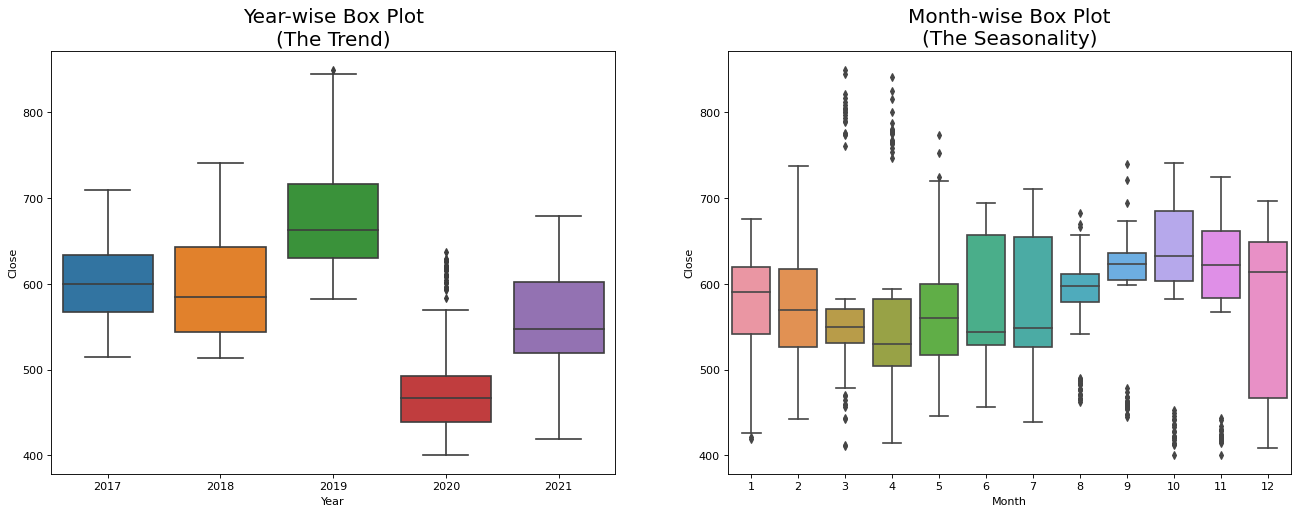

In [31]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='Close', data=df_any_one_stock, ax=axes[0])
sns.boxplot(x='Month', y='Close', data=df_any_one_stock.loc[~df_any_one_stock.Year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [32]:
# Augmented Dicky Fuller Test for stationarity
# create a function

def adfuller_test(data):

  #H0: Non-Stationary
  #H1: Stationary

    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
  
    if result[1] > 0.05:
        print('Conclusion: Pvalue > 0.05 , so we fail to reject H0. We conclude the time series is non-stationary')
    else:
        print('Conclusion: Pvalue < 0.05 , so we reject H0. We conclude the time series is stationary')


In [33]:
adfuller_test(df_any_one_stock['Close'].dropna())

ADF Statistic: -2.124269
p-value: 0.234869
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Conclusion: Pvalue > 0.05 , so we fail to reject H0. We conclude the time series is non-stationary


In [34]:
# make stationary by calculating the first order difference
df_any_one_stock['diff'] = df_any_one_stock['Close']-df_any_one_stock['Close'].shift(1)

adfuller_test(df_any_one_stock['diff'].dropna())

ADF Statistic: -34.230868
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Conclusion: Pvalue < 0.05 , so we reject H0. We conclude the time series is stationary


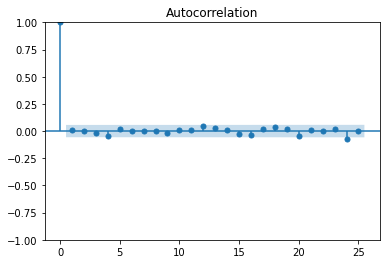

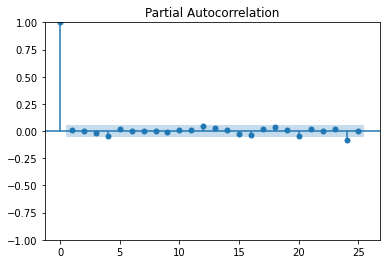

In [35]:
# ACF Plot and PACF plot


sm.graphics.tsa.plot_acf(df_any_one_stock['diff'].dropna(),lags =25)
sm.graphics.tsa.plot_pacf(df_any_one_stock['diff'].dropna(),lags =25)

plt.show()

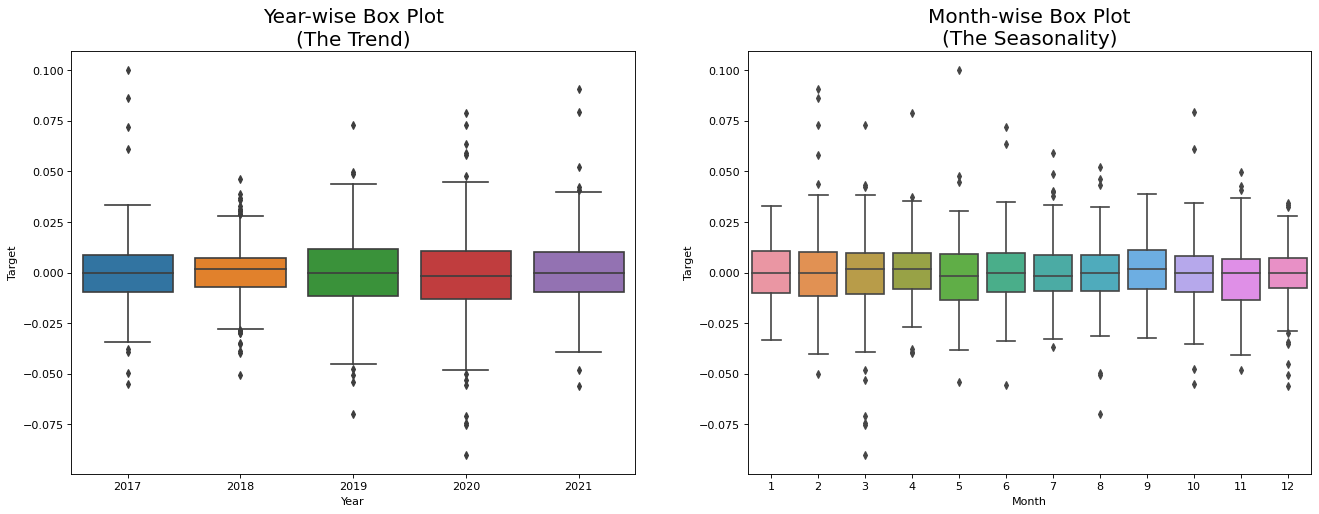

In [36]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='Target', data=df_any_one_stock, ax=axes[0])
sns.boxplot(x='Month', y='Target', data=df_any_one_stock.loc[~df_any_one_stock.Year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()